In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import matplotlib.pyplot as plt
import seaborn

# Some plotting config
seaborn.set(
    context="notebook",
    # style="ticks",
    style="darkgrid",
    font="Times New Roman",
    font_scale=1.75,
)
plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
# plt.rcParams["xtick.top"] = True
# plt.rcParams["ytick.right"] = True
# plt.rcParams["xtick.bottom"] = True
# plt.rcParams["ytick.left"] = True
plt.rcParams["mathtext.fontset"] = "cm"

from tqdm.auto import tqdm, trange

from ssptools import evolve_mf_3 as emf3
from limepy import limepy

import numpy as np
import scipy as sp
import astropy.units as u
import astropy.constants as const

from binaryshift import BinaryShift

In [2]:
m123 = [0.1, 0.5, 1.0, 100]  # Slope breakpoints for initial mass function
a12 = [-0.468, -1.178, -2.117]  # Slopes for initial mass function
a12 = [-0.3, -1.3, -2.3]  # Slopes for initial mass function


# up the number of low mass bins from 5 to 15, fixes the mass ratio distribution and doens't have a have impact on runtime
nbin12 = [15, 5, 20]


# Output times for the evolution
tout = np.array([11000])

# Integration settings
N0 = 5e6  # Normalization of stars
Ndot = 0.0  # -0.0001  # Regulates how low mass objects are depleted default -20, 0 for 47 Tuc
tcc = 0  # Core collapse time
NS_ret = 0.1  # Initial neutron star retention
BH_ret_int = 1  # Initial Black Hole retention
BH_ret_dyn = 0.00235  # Dynamical Black Hole retention
FeHe = -0.7  # Metallicity

In [3]:
f = emf3.evolve_mf(
    m123=m123,
    a12=a12,
    nbin12=nbin12,
    tout=tout,
    N0=N0,
    Ndot=Ndot,
    tcc=tcc,
    NS_ret=NS_ret,
    BH_ret_int=BH_ret_int,
    BH_ret_dyn=BH_ret_dyn,
    FeHe=FeHe,
    natal_kicks=True,
    vesc=100,
)

In [4]:
f

In [5]:
cs = f.Ns[-1] > 10 * f.Nmin
cr = f.Nr[-1] > 10 * f.Nmin
mj = np.r_[f.ms[-1][cs], f.mr[-1][cr]]
Mj = np.r_[f.Ms[-1][cs], f.Mr[-1][cr]]
dms = f.mes[-1][1:] - f.mes[-1][0:-1]
nms = len(f.ms[-1][cs])

In [6]:
f.Nmin

0.1

In [7]:
Mj / mj

array([8.15439217e+04, 8.79043150e+04, 9.47608166e+04, 1.02152122e+05,
       1.10119947e+05, 1.18709259e+05, 1.27968534e+05, 1.37950029e+05,
       1.48710076e+05, 1.60309403e+05, 1.72813472e+05, 1.86292854e+05,
       2.00823622e+05, 2.16487785e+05, 2.33373746e+05, 3.06571734e+05,
       2.94083264e+05, 2.82103523e+05, 2.46702762e+05, 7.18508214e+05,
       4.94101905e+05, 9.34994217e+04, 8.16264703e+04, 1.46248291e+05,
       1.45058480e+04, 7.32300749e+00, 1.19583568e+01, 1.77342985e+01,
       2.79599451e+01, 4.82943067e+01, 1.87004258e+01])

In [8]:
bs = BinaryShift(mj=mj, Mj=Mj, MF=f, verbose=False)

In [9]:
bs.MS_mask_original

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False])

In [10]:
bs.mj[bs.MS_mask_original]

array([0.10563281, 0.11759716, 0.13091663, 0.14574472, 0.16225228,
       0.18062956, 0.20108831, 0.22386429, 0.24921996, 0.2774475 ,
       0.3088722 , 0.34385617, 0.38280255, 0.42616013, 0.47442855,
       0.53605839, 0.61576939, 0.70733328, 0.80741259])

In [11]:
mj_new, Mj_new = bs.shift_flat(fb=0.05)
# mj_new, Mj_new = bs.shift_equal(fb=0.25)
# mj_new, Mj_new = bs.shift_solar(fb=0.25)

In [12]:
bs._q_min

0.13082878242190252

Text(0.5, 0, 'mj [$M_\\odot$]')

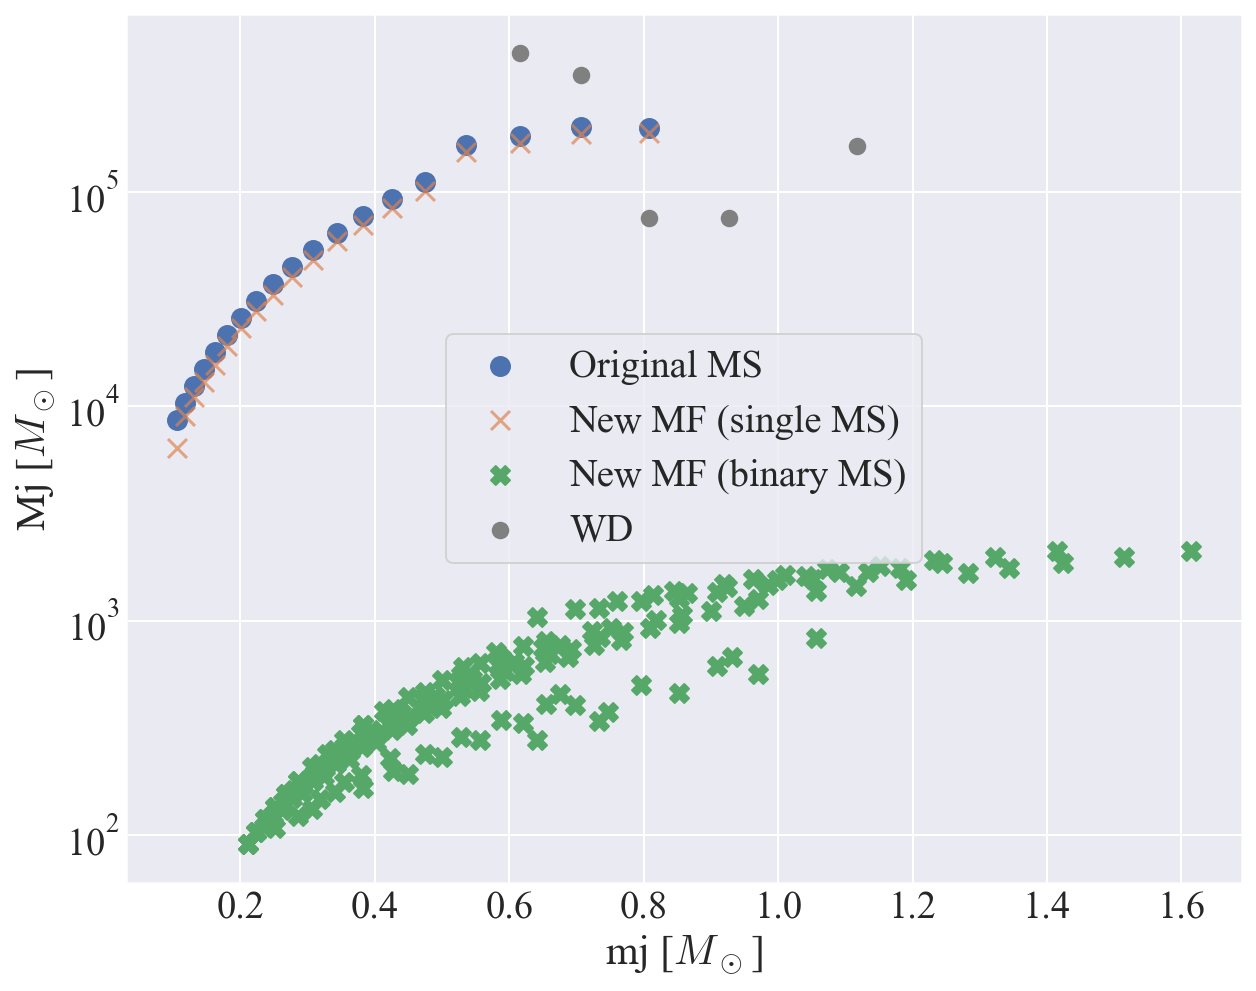

In [13]:
plt.figure()
plt.scatter(mj[bs.MS_mask_original], Mj[bs.MS_mask_original], label="Original MS", s=90)

# plt.scatter(mj, Mj, label="Original MF", s=70)

plt.yscale("log")
# plt.ylim(1e2, 1e5)
plt.scatter(
    mj_new[bs.MS_mask],
    Mj_new[bs.MS_mask],
    label="New MF (single MS)",
    marker="x",
    s=90,
    alpha=0.7,
)
plt.scatter(
    mj_new[bs.bin_mask],
    Mj_new[bs.bin_mask],
    label="New MF (binary MS)",
    marker="X",
    s=90,
)
plt.scatter(
    mj_new[bs.WD_mask],
    Mj_new[bs.WD_mask],
    label="WD",
    marker="o",
    color="grey",
    s=60,
)

plt.legend()
plt.ylabel(r"Mj [$M_\odot$]")
plt.xlabel(r"mj [$M_\odot$]")
# plt.savefig("shifted.png",dpi=300)
# plt.xlim(0, 1.7)

In [14]:
mj

array([0.10563281, 0.11759716, 0.13091663, 0.14574472, 0.16225228,
       0.18062956, 0.20108831, 0.22386429, 0.24921996, 0.2774475 ,
       0.3088722 , 0.34385617, 0.38280255, 0.42616013, 0.47442855,
       0.53605839, 0.61576939, 0.70733328, 0.80741259, 0.61576939,
       0.70733328, 0.80741259, 0.9275805 , 1.11806267, 1.40755751,
       2.80844646, 3.53562462, 4.45108767, 5.60358738, 7.05449855,
       8.8810875 ])

In [15]:
# Mass ratio
np.sum(Mj_new[bs.bin_mask]) / np.sum(Mj_new[bs.MS_mask])

0.08587620817570508

In [16]:
# check mass conservation
print(f"{np.sum(Mj) = :.3f}, {np.sum(Mj_new) = :.3f}")

np.sum(Mj) = 2493032.765, np.sum(Mj_new) = 2493032.765


In [17]:
# Have a look at Nj

In [18]:
Nj = Mj_new / mj_new

In [19]:
Nj[bs.bin_mask]

array([ 431.44932099,  465.10219598,  501.3799818 ,  540.48742045,
        582.64522373, 1145.43801502, 1234.78172344, 1622.07266453,
       1555.99610602, 1492.61123432, 1305.30561839,  431.44932099,
        465.10219598,  501.3799818 ,  540.48742045,  582.64522373,
        628.09131884,  677.08219125,  729.89433218,  786.82579904,
        848.19789761,  914.35699539,  985.67647643, 1062.55884854,
       1145.43801502, 1234.78172344, 1622.07266453, 1555.99610602,
       1492.61123432, 1305.30561839,  431.44932099,  465.10219598,
        501.3799818 ,  540.48742045,  582.64522373,  628.09131884,
        677.08219125,  729.89433218,  786.82579904,  848.19789761,
        914.35699539,  985.67647643, 1062.55884854, 1145.43801502,
       1234.78172344, 1622.07266453, 1555.99610602, 1492.61123432,
       1305.30561839,  431.44932099,  465.10219598,  501.3799818 ,
        540.48742045,  582.64522373,  628.09131884,  677.08219125,
        729.89433218,  786.82579904,  848.19789761,  914.35699

In [20]:
Nj[bs.MS_mask]

array([ 60673.49134485,  76688.89198124,  84347.9581572 ,  89003.00470363,
        96423.0560137 , 105740.37444669, 115072.47832059, 124035.04739426,
       133137.51101249, 144391.62688525, 156442.10924604, 171553.54663269,
       183391.40899343, 198043.917755  , 213204.2819418 , 284982.99944736,
       274130.81262853, 263924.64138035, 232280.23466913])

In [21]:
# This is the bad (old) definition
np.sum(Nj[bs.bin_mask]) / np.sum(Nj[bs.MS_mask])

0.05019402596681124

In [22]:
# This is the definition we want to use
print(f"Binary Fraction: {bs.fb_true * 100:.3f}")

Binary Fraction: 4.780


In [23]:
print(f"Input fb | True fb | Diff")
print("---------------------------")
bs.verbose = False
for fb in np.linspace(0, 0.7, 71):
    bs.shift_flat(fb=fb)
    # bs.shift_solar(fb=fb)
    # bs._shift_q(fb=[0.2,0.2],q=[1,1])

    print(f"{fb*100:.1f}  | {bs.fb_true*100:.2f} | {-1*(fb - bs.fb_true)*100:.2f}")

Input fb | True fb | Diff
---------------------------
0.0  | 0.00 | -0.00
1.0  | 0.96 | -0.04
2.0  | 1.91 | -0.09
3.0  | 2.87 | -0.13
4.0  | 3.83 | -0.17
5.0  | 4.78 | -0.22
6.0  | 5.73 | -0.27
7.0  | 6.69 | -0.31
8.0  | 7.64 | -0.36
9.0  | 8.59 | -0.41
10.0  | 9.54 | -0.46
11.0  | 10.49 | -0.51
12.0  | 11.44 | -0.56
13.0  | 12.39 | -0.61
14.0  | 13.33 | -0.67
15.0  | 14.28 | -0.72
16.0  | 15.22 | -0.78
17.0  | 16.17 | -0.83
18.0  | 17.11 | -0.89
19.0  | 18.06 | -0.94
20.0  | 19.00 | -1.00
21.0  | 19.94 | -1.06
22.0  | 20.88 | -1.12
23.0  | 21.81 | -1.19
24.0  | 22.69 | -1.31
25.0  | 23.52 | -1.48
26.0  | 24.41 | -1.59
27.0  | 25.24 | -1.76
28.0  | 26.07 | -1.93
29.0  | 26.96 | -2.04
30.0  | 27.79 | -2.21
31.0  | 28.63 | -2.37
32.0  | 29.46 | -2.54
33.0  | 30.29 | -2.71
34.0  | 31.09 | -2.91
35.0  | 31.91 | -3.09
36.0  | 32.74 | -3.26
37.0  | 33.56 | -3.44
38.0  | 34.39 | -3.61
39.0  | 35.21 | -3.79
40.0  | 36.03 | -3.97
41.0  | 36.85 | -4.15
42.0  | 37.63 | -4.37
43.0  | 38.45 | -4.55

In [24]:
fbs = np.linspace(0, 0.1, 31)

true_fbs = []

for fb in fbs:
    bs.shift_flat(fb=fb)
    # bs.shift_solar(fb=fb)

    # bs.shift_q(fb=[fb],q=[0.4])

    true_fbs.append(bs.fb_true)

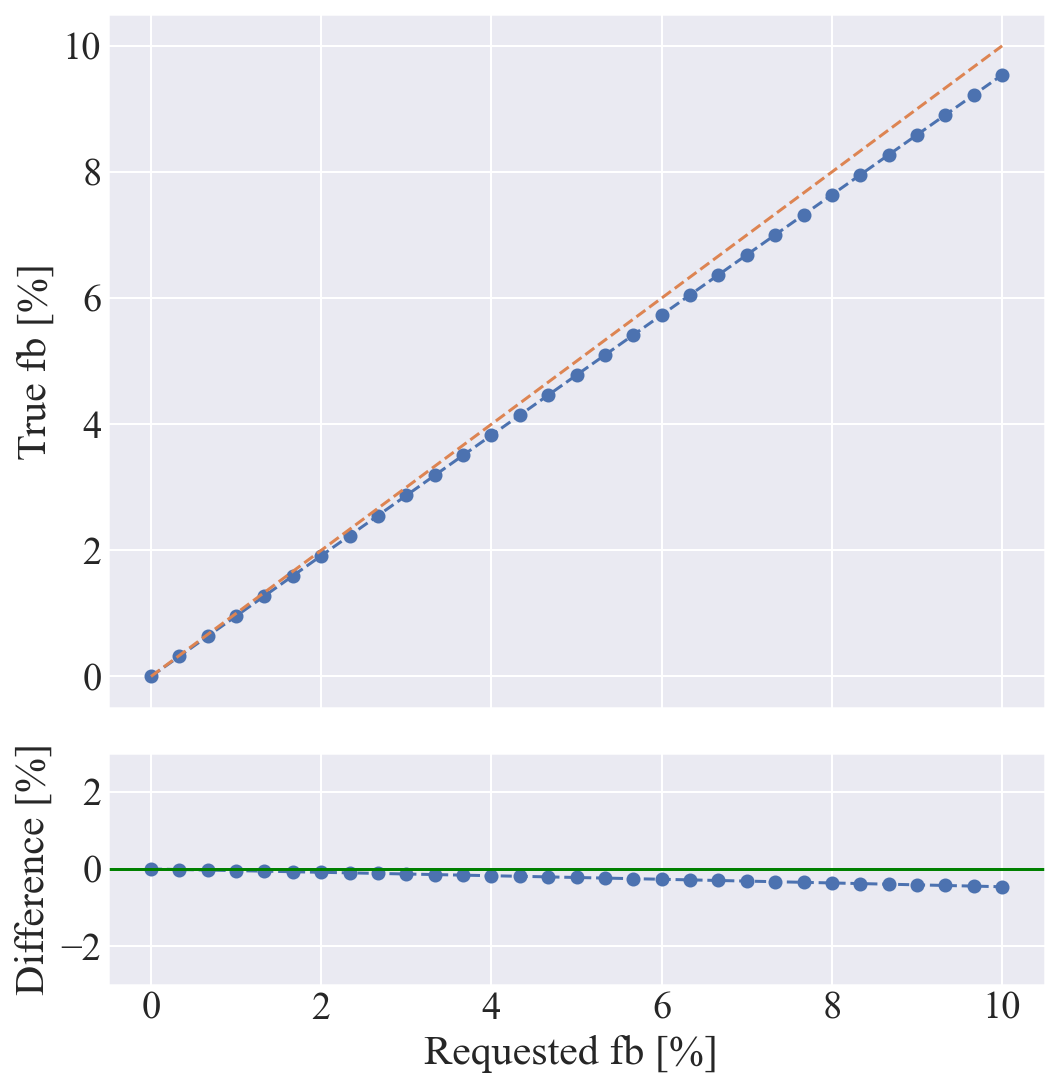

In [25]:
fig, axes = plt.subplots(
    2, 1, figsize=(8, 8), sharex=True, gridspec_kw={"height_ratios": [3, 1]}
)
axes[0].plot(np.array(fbs) * 100, np.array(true_fbs) * 100, "o--")
axes[1].set_xlabel("Requested fb [%] ")
axes[0].set_ylabel("True fb [%]")
axes[1].plot(np.array(fbs) * 100, np.array(true_fbs - fbs) * 100, "o--")
axes[0].plot(np.array(fbs) * 100, np.array(fbs) * 100, "--")

axes[1].set_ylabel("Difference [%]")
axes[1].set_ylim(-3, 3)
axes[1].axhline(0, color="green")
fig.tight_layout()

In [26]:
plt.close("all")

# Have a look at mass ratio distribution:


In [27]:
mj_new, Mj_new = bs.shift_flat(fb=0.05)
# mj_new, Mj_new = bs.shift_solar(fb=0.15)

# mj_new, Mj_new = bs._shift_q(fb=[0.05,0.05,0.05],q=[1,0.5,0.8])

In [28]:
bs.q_values[0:5]

[0.19705466424302095,
 0.1909759680553411,
 0.2126065892886884,
 0.20604815095509624,
 0.200953373242031]

In [29]:
len(bs.Nj_shifted[bs.bin_mask])

163

In [30]:
# qs

In [31]:
q_vals = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [32]:
q_counts = []

for q, N in zip(bs.q_values, bs.Nj_shifted[bs.bin_mask]):
    q_count = [q] * int(N)
    q_counts.append(q_count)

In [33]:
q_counts = np.hstack(q_counts).flatten()

<AxesSubplot:ylabel='Count'>

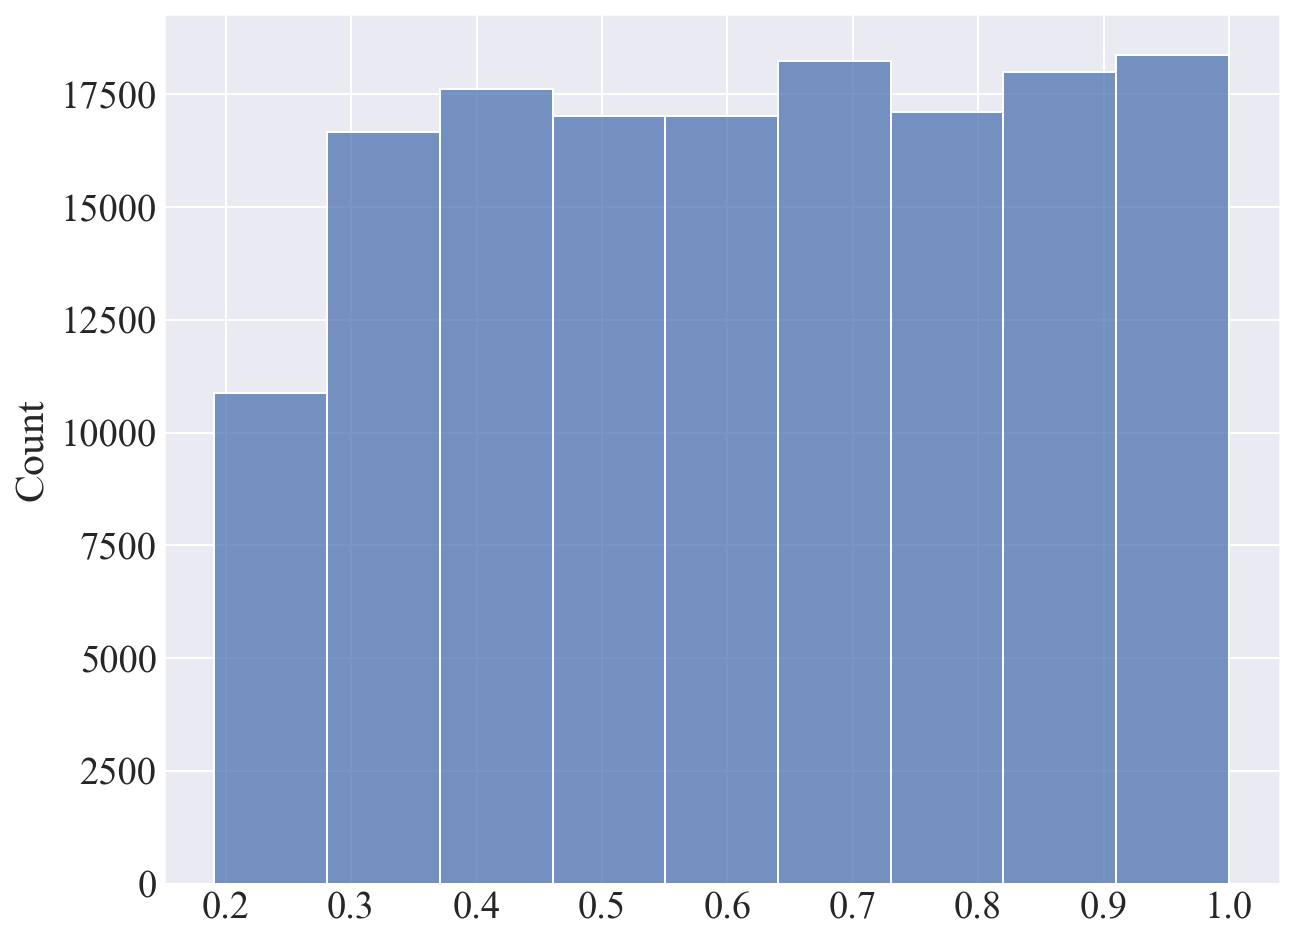

In [34]:
plt.figure()
seaborn.histplot(q_counts, stat="count", bins=9)

# Now lets re-bin/re-sample the binary bins so that instead of adding like 150+ bins we only add like 15 ish



In [35]:
np.min(mj_new[bs.bin_mask])

0.21126561148583806

In [36]:
np.max(mj_new[bs.bin_mask])

1.614825175124991

In [37]:
len(mj_new[bs.bin_mask]), len(bs.q_values)

(163, 163)

In [38]:
count, binned = np.histogram(mj_new[bs.bin_mask], bins=15)

In [39]:
binned

array([0.21126561, 0.30483625, 0.39840689, 0.49197752, 0.58554816,
       0.6791188 , 0.77268944, 0.86626007, 0.95983071, 1.05340135,
       1.14697199, 1.24054262, 1.33411326, 1.4276839 , 1.52125454,
       1.61482518])

In [40]:
binned = np.array([(binned[i] + binned[i + 1]) / 2 for i in range(len(binned) - 1)])

In [41]:
len(binned)

15

In [42]:
binned

array([0.25805093, 0.35162157, 0.44519221, 0.53876284, 0.63233348,
       0.72590412, 0.81947476, 0.91304539, 1.00661603, 1.10018667,
       1.19375731, 1.28732794, 1.38089858, 1.47446922, 1.56803986])

In [43]:
bin_idxs = [(np.abs(binned - mj)).argmin() for mj in mj_new[bs.bin_mask]]

In [44]:
for i, mj in enumerate(mj_new[bs.bin_mask]):
    print(
        f"{mj = :.2f} \t binned: {binned[bin_idxs[i]]:.2f} \t diff: {np.abs(mj - binned[bin_idxs[i]]):.2f} \t q: {bs.q_values[i]:.2f}"
    )

mj = 0.64 	 binned: 0.63 	 diff: 0.01 	 q: 0.20
mj = 0.73 	 binned: 0.73 	 diff: 0.01 	 q: 0.19
mj = 0.75 	 binned: 0.73 	 diff: 0.02 	 q: 0.21
mj = 0.85 	 binned: 0.82 	 diff: 0.03 	 q: 0.21
mj = 0.97 	 binned: 1.01 	 diff: 0.04 	 q: 0.20
mj = 0.53 	 binned: 0.54 	 diff: 0.01 	 q: 0.25
mj = 0.58 	 binned: 0.54 	 diff: 0.04 	 q: 0.22
mj = 0.64 	 binned: 0.63 	 diff: 0.01 	 q: 0.20
mj = 0.73 	 binned: 0.73 	 diff: 0.01 	 q: 0.19
mj = 0.85 	 binned: 0.82 	 diff: 0.03 	 q: 0.21
mj = 0.97 	 binned: 1.01 	 diff: 0.04 	 q: 0.20
mj = 0.45 	 binned: 0.45 	 diff: 0.00 	 q: 0.31
mj = 0.50 	 binned: 0.54 	 diff: 0.04 	 q: 0.31
mj = 0.56 	 binned: 0.54 	 diff: 0.02 	 q: 0.31
mj = 0.62 	 binned: 0.63 	 diff: 0.01 	 q: 0.31
mj = 0.70 	 binned: 0.73 	 diff: 0.03 	 q: 0.30
mj = 0.80 	 binned: 0.82 	 diff: 0.02 	 q: 0.29
mj = 0.91 	 binned: 0.91 	 diff: 0.00 	 q: 0.28
mj = 0.93 	 binned: 0.91 	 diff: 0.02 	 q: 0.32
mj = 1.06 	 binned: 1.10 	 diff: 0.04 	 q: 0.31
mj = 0.38 	 binned: 0.35 	 diff: 0.03 	 

In [45]:
dms[:nms]

array([0.01132636, 0.01260922, 0.01403739, 0.01562731, 0.01739732,
       0.0193678 , 0.02156147, 0.02400359, 0.02672233, 0.02974899,
       0.03311847, 0.03686959, 0.04104557, 0.04569454, 0.05087006,
       0.07434918, 0.08540478, 0.09810433, 0.10189271])

In [46]:
# Good to go with 160 -> 15 bins, shouldnt be too slow

In [47]:
# somehwere along the way these get mangled, reset them here
cs = f.Ns[-1] > 10 * f.Nmin
cr = f.Nr[-1] > 10 * f.Nmin
mj = np.r_[f.ms[-1][cs], f.mr[-1][cr]]
Mj = np.r_[f.Ms[-1][cs], f.Mr[-1][cr]]
dms = f.mes[-1][1:] - f.mes[-1][0:-1]
nms = len(f.ms[-1][cs])

Text(0.5, 0, 'mj [$M_\\odot$]')

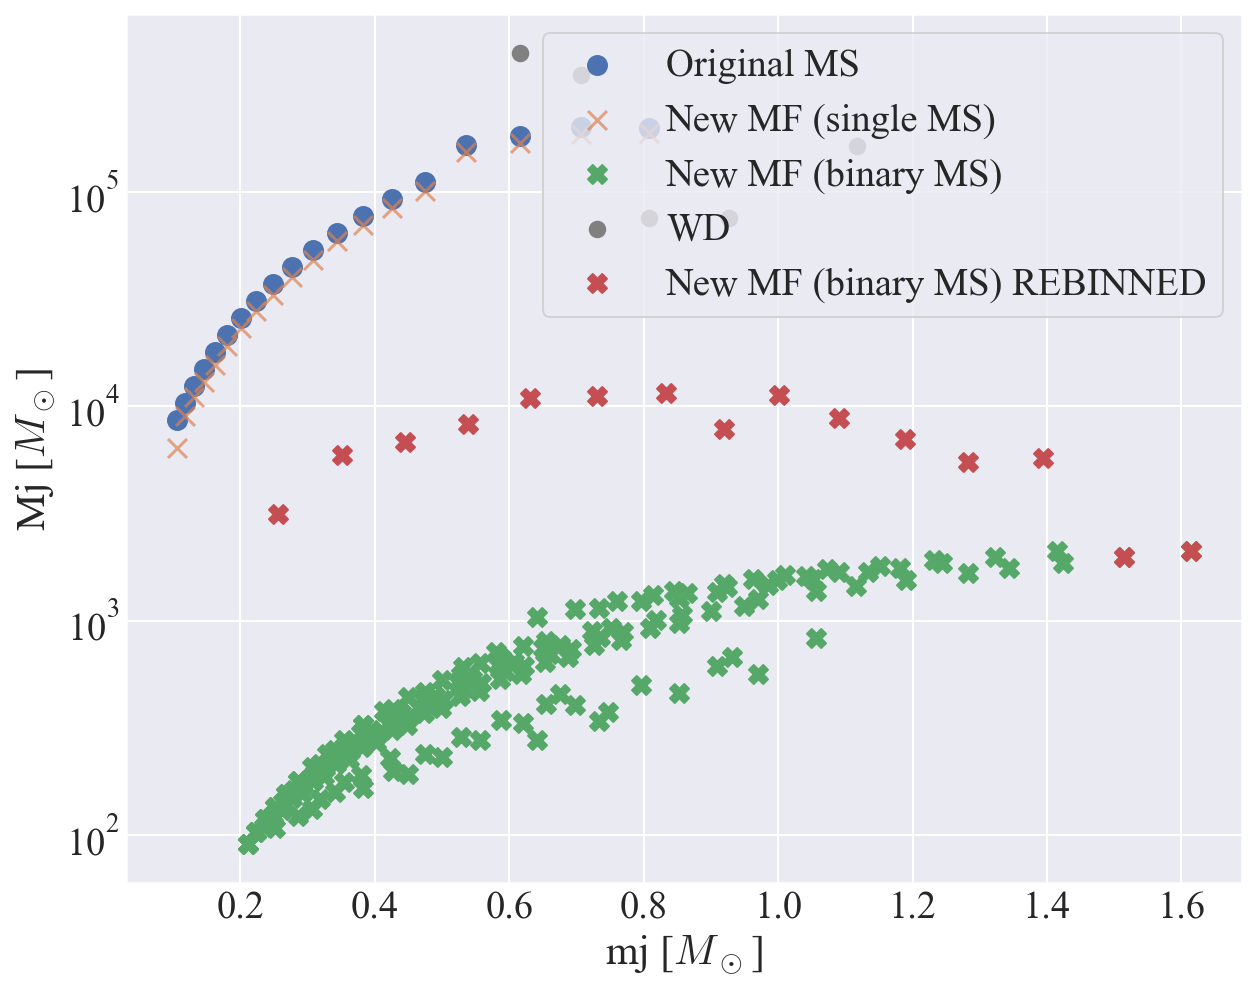

In [48]:
plt.figure()
plt.scatter(mj[bs.MS_mask_original], Mj[bs.MS_mask_original], label="Original MS", s=90)

# plt.scatter(mj, Mj, label="Original MF", s=70)

plt.yscale("log")
# plt.ylim(1e2, 1e5)
plt.scatter(
    mj_new[bs.MS_mask],
    Mj_new[bs.MS_mask],
    label="New MF (single MS)",
    marker="x",
    s=90,
    alpha=0.7,
)
plt.scatter(
    mj_new[bs.bin_mask],
    Mj_new[bs.bin_mask],
    label="New MF (binary MS)",
    marker="X",
    s=90,
)
plt.scatter(
    mj_new[bs.WD_mask],
    Mj_new[bs.WD_mask],
    label="WD",
    marker="o",
    color="grey",
    s=60,
)

# rebin
new_mj_binned, new_Mj_binned = bs.rebin()

plt.scatter(
    new_mj_binned[bs.bin_mask],
    new_Mj_binned[bs.bin_mask],
    label="New MF (binary MS) REBINNED",
    marker="X",
    s=90,
)

plt.legend()
plt.ylabel(r"Mj [$M_\odot$]")
plt.xlabel(r"mj [$M_\odot$]")
# plt.savefig("shifted.png",dpi=300)
# plt.xlim(0, 1.7)

In [49]:
bs.rebin()

(array([0.10563281, 0.11759716, 0.13091663, 0.14574472, 0.16225228,
        0.18062956, 0.20108831, 0.22386429, 0.24921996, 0.2774475 ,
        0.3088722 , 0.34385617, 0.38280255, 0.42616013, 0.47442855,
        0.53605839, 0.61576939, 0.70733328, 0.80741259, 0.61576939,
        0.70733328, 0.80741259, 0.9275805 , 1.11806267, 1.40755751,
        2.80844646, 3.53562462, 4.45108767, 5.60358738, 7.05449855,
        8.8810875 , 0.25552595, 0.35144883, 0.44490773, 0.53812807,
        0.63119964, 0.73107885, 0.83334361, 0.92001048, 1.00135046,
        1.09008917, 1.18885325, 1.28281942, 1.39472692, 1.51474587,
        1.61482518]),
 array([6.40911112e+03, 9.01839553e+03, 1.10425504e+04, 1.29717176e+04,
        1.56448610e+04, 1.90998370e+04, 2.31397298e+04, 2.77670175e+04,
        3.31805248e+04, 4.00610961e+04, 4.83206181e+04, 5.89897451e+04,
        7.02026985e+04, 8.43984223e+04, 1.01150199e+05, 1.52767527e+05,
        1.68801363e+05, 1.86682683e+05, 1.87545985e+05, 4.42435364e+05,
      

In [50]:
bs.q_values

[[BinaryPop(mj=0.2678850888116792, q=0.6510404892001018, Mj=156.08196750348375),
  BinaryPop(mj=0.28626236274328204, q=0.5848035476425751, Mj=179.79890495004585),
  BinaryPop(mj=0.28626236274328204, q=0.5848035476425751, Mj=123.50770203011263),
  BinaryPop(mj=0.25137752104979455, q=0.7247796636776976, Mj=135.86638791248816),
  BinaryPop(mj=0.2678850888116792, q=0.6510404892001018, Mj=156.08196750348375),
  BinaryPop(mj=0.28626236274328204, q=0.5848035476425751, Mj=179.79890495004585),
  BinaryPop(mj=0.25137752104979455, q=0.7247796636776976, Mj=108.45666076867101),
  BinaryPop(mj=0.22322996089643288, q=0.8982598737616032, Mj=103.82474502170022),
  BinaryPop(mj=0.23654943531589345, q=0.8068708008102065, Mj=118.60115157438787),
  BinaryPop(mj=0.25137752104979455, q=0.7247796636776976, Mj=135.86638791248816),
  BinaryPop(mj=0.27984943822227404, q=0.7247796636776931, Mj=163.0529385425533),
  BinaryPop(mj=0.21126561148583806, q=1.0, Mj=91.15040462375549),
  BinaryPop(mj=0.22322996089643288,

In [51]:
bs.mj_shifted

array([0.10563281, 0.11759716, 0.13091663, 0.14574472, 0.16225228,
       0.18062956, 0.20108831, 0.22386429, 0.24921996, 0.2774475 ,
       0.3088722 , 0.34385617, 0.38280255, 0.42616013, 0.47442855,
       0.53605839, 0.61576939, 0.70733328, 0.80741259, 0.61576939,
       0.70733328, 0.80741259, 0.9275805 , 1.11806267, 1.40755751,
       2.80844646, 3.53562462, 4.45108767, 5.60358738, 7.05449855,
       8.8810875 , 0.25552595, 0.35144883, 0.44490773, 0.53812807,
       0.63119964, 0.73107885, 0.83334361, 0.92001048, 1.00135046,
       1.09008917, 1.18885325, 1.28281942, 1.39472692, 1.51474587,
       1.61482518])

In [52]:
bs.mj_shifted[bs.bin_mask]

array([0.25552595, 0.35144883, 0.44490773, 0.53812807, 0.63119964,
       0.73107885, 0.83334361, 0.92001048, 1.00135046, 1.09008917,
       1.18885325, 1.28281942, 1.39472692, 1.51474587, 1.61482518])

In [53]:
bs.bin_mask

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [54]:
# Have a look at models
stop

NameError: name 'stop' is not defined

In [55]:
l = limepy(
    M=1e6, phi0=6, g=0.8, mj=mj, Mj=Mj, delta=0.45, rh=8, ra=10**1.23, project=True
)

In [56]:
l_bin = limepy(
    M=1e6,
    phi0=6,
    g=0.8,
    mj=mj_new,
    Mj=Mj_new,
    delta=0.45,
    rh=8,
    ra=10**1.23,
    project=True,
)

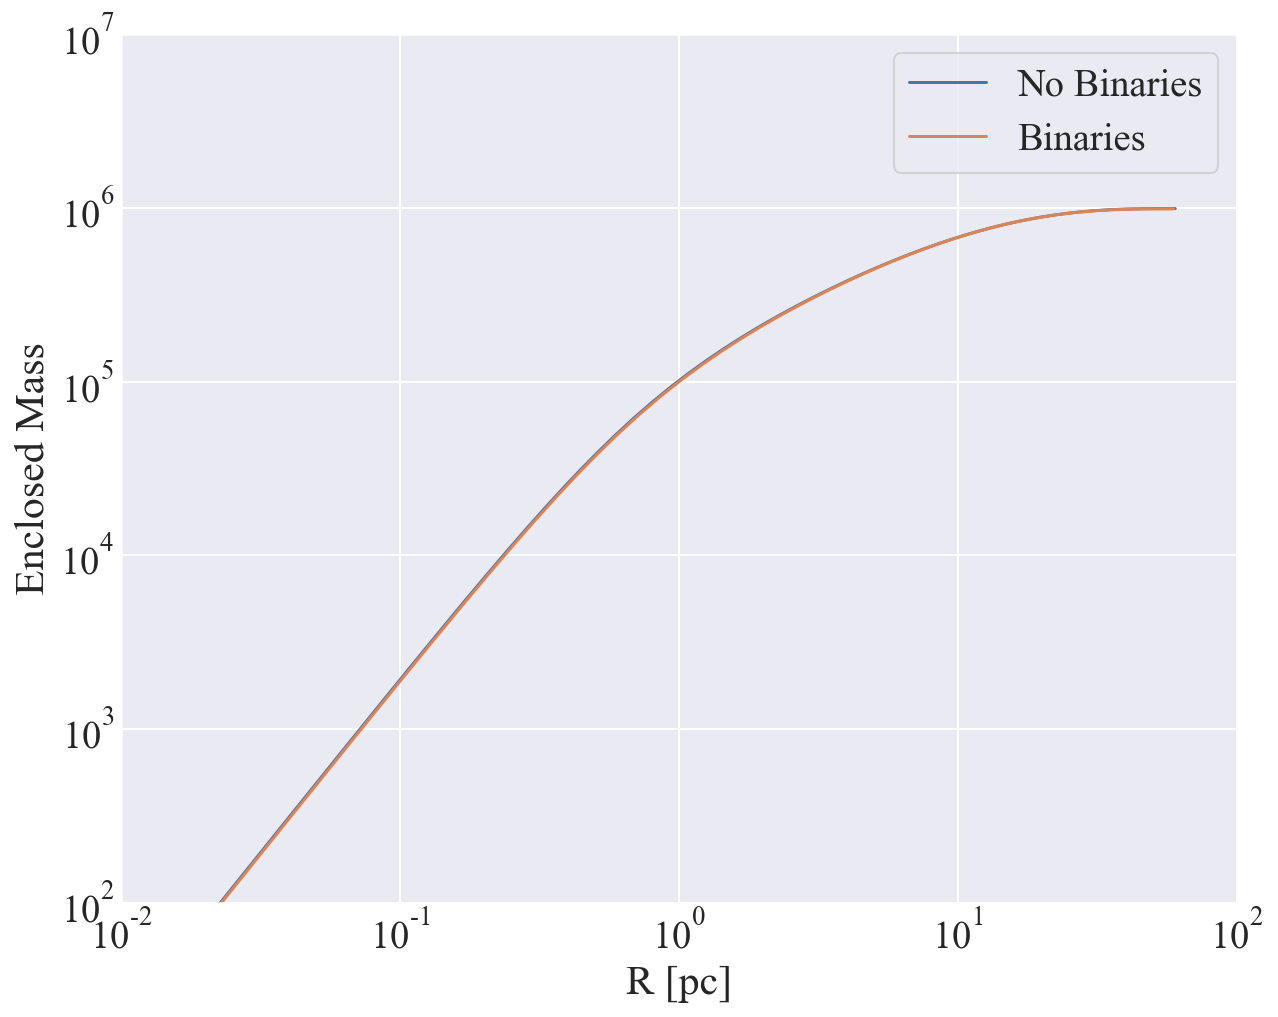

In [57]:
plt.figure()
plt.loglog()
plt.xlim(1e-2, 1e2)
plt.ylim(1e2, 1e7)
plt.plot(l.r, l.mcp, label="No Binaries")
plt.xlabel("R [pc]")
plt.ylabel("Enclosed Mass")
plt.plot(l_bin.r, l_bin.mcp, label="Binaries")
plt.legend()

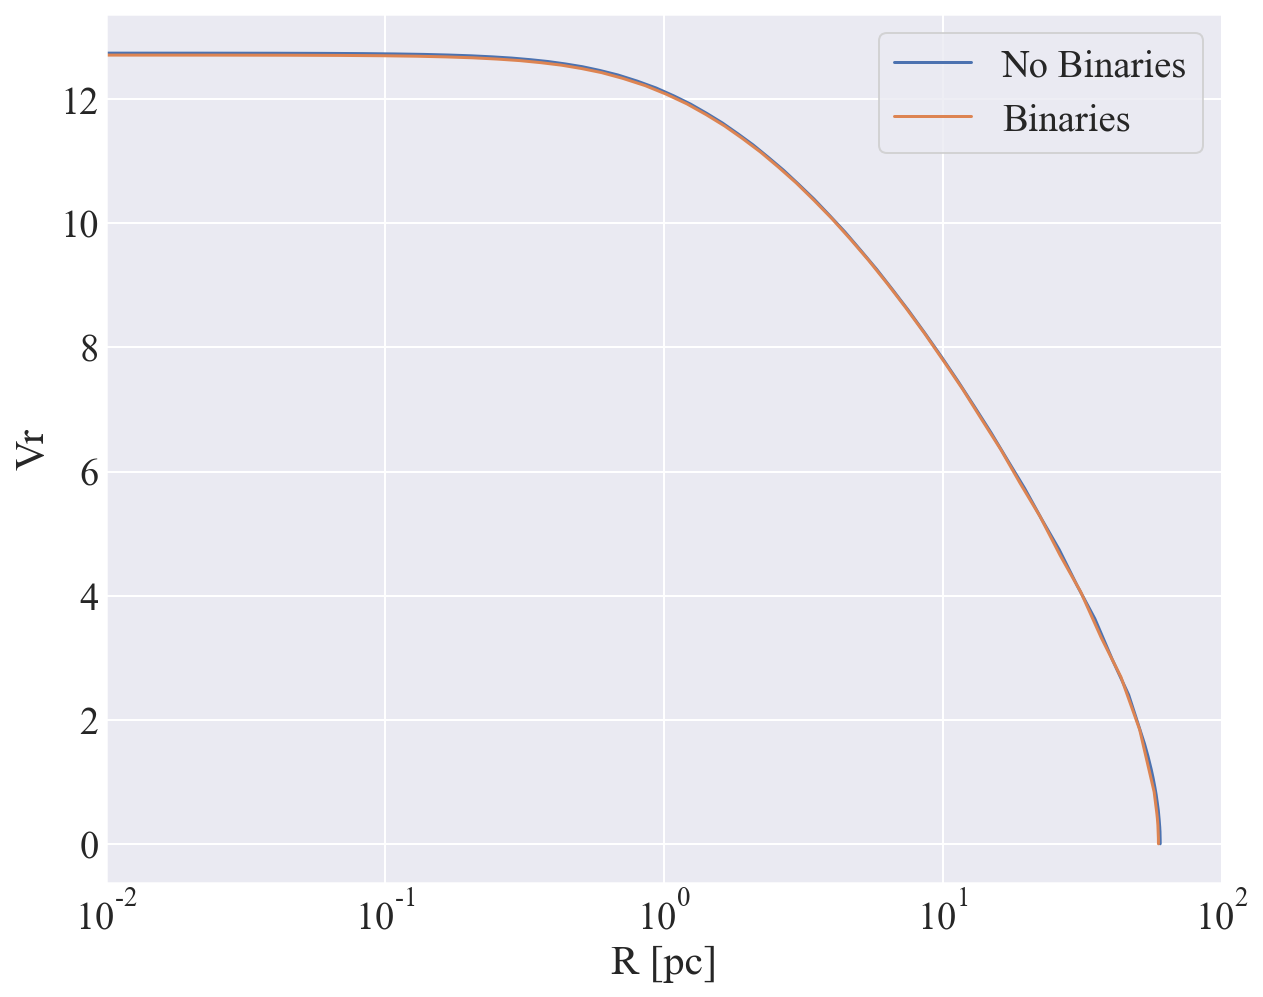

In [58]:
plt.figure()
plt.xscale("log")
plt.xlim(1e-2, 1e2)
plt.plot(l.r, np.sqrt(l.v2R), label="No Binaries")
plt.xlabel("R [pc]")
plt.ylabel("Vr")
plt.plot(l_bin.r, np.sqrt(l_bin.v2R), label="Binaries")
plt.legend()

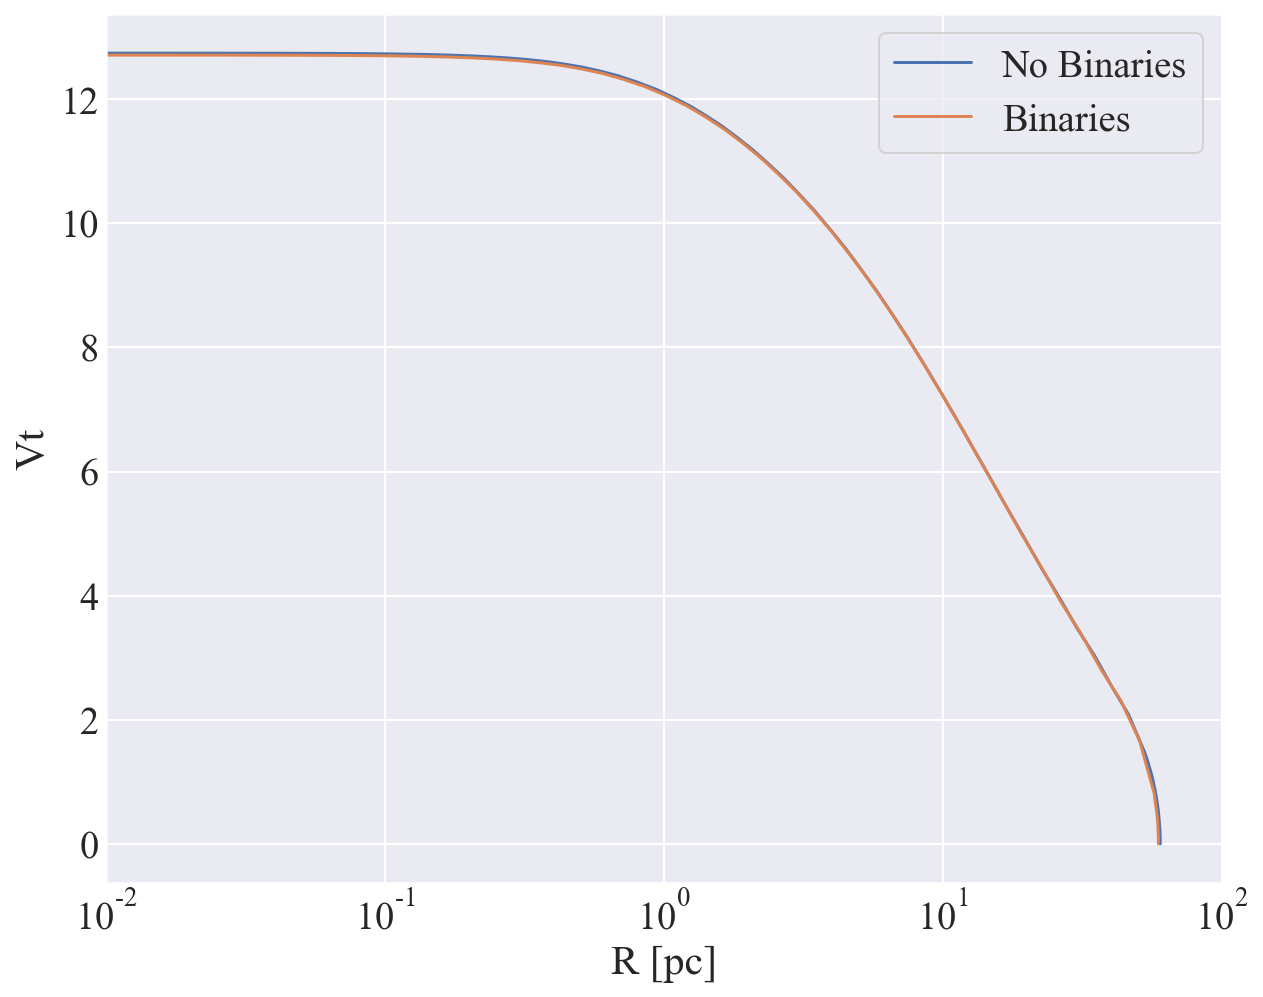

In [59]:
plt.figure()
plt.xscale("log")
plt.xlim(1e-2, 1e2)
plt.plot(l.r, np.sqrt(l.v2T), label="No Binaries")
plt.xlabel("R [pc]")
plt.ylabel("Vt")
plt.plot(l_bin.r, np.sqrt(l_bin.v2T), label="Binaries")
plt.legend()

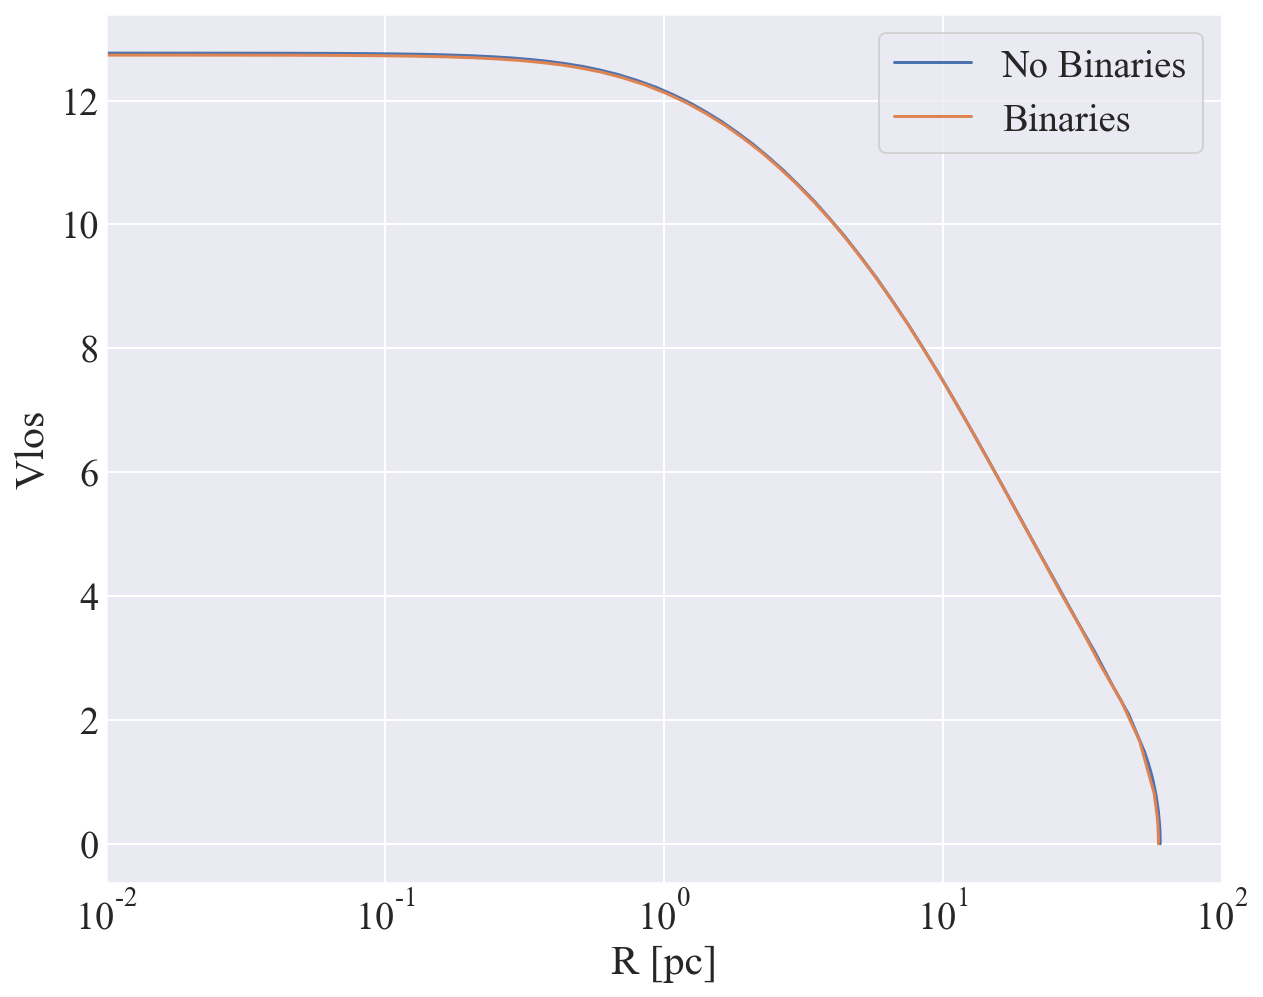

In [60]:
plt.figure()
plt.xscale("log")
plt.xlim(1e-2, 1e2)
plt.plot(l.r, np.sqrt(l.v2p), label="No Binaries")
plt.xlabel("R [pc]")
plt.ylabel("Vlos")
plt.plot(l_bin.r, np.sqrt(l_bin.v2p), label="Binaries")
plt.legend()

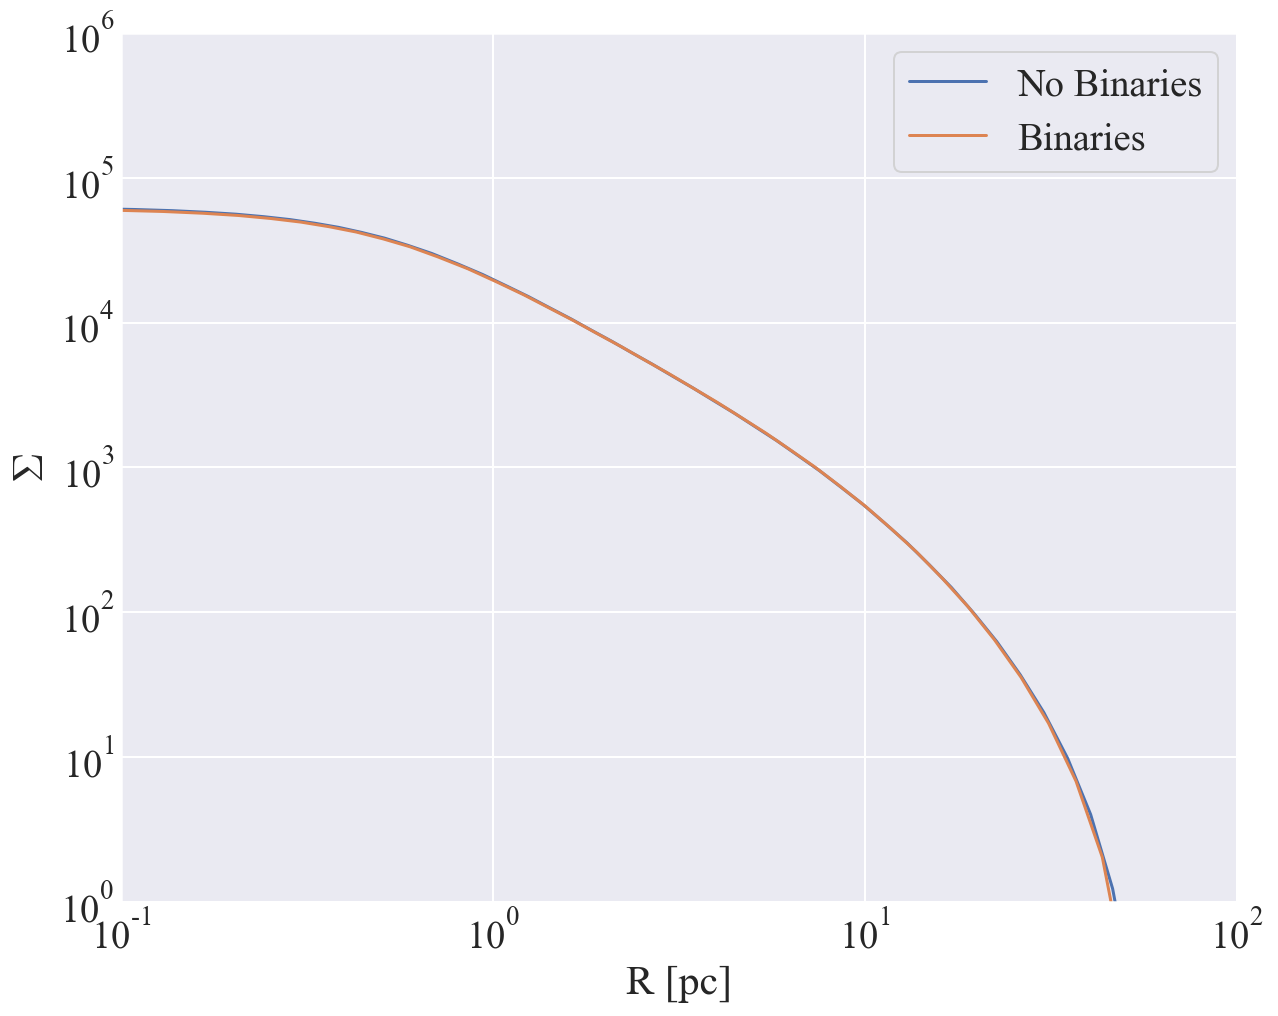

In [61]:
plt.figure()
plt.loglog()
plt.xlim(1e-1, 1e2)
plt.ylim(1e-0, 1e6)
plt.plot(l.r, l.Sigma, label="No Binaries")
plt.xlabel("R [pc]")
plt.ylabel(r"$\Sigma$")
plt.plot(l_bin.r, l_bin.Sigma, label="Binaries")
plt.legend()